<a href="https://colab.research.google.com/github/bruaba/mask_detection/blob/main/Projet_Mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 29 18:40:11 2020

@author: cheikh
"""
#libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random as rand
import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
from PIL import Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from keras_radam import RAdam
from imutils import paths
from bs4 import BeautifulSoup

In [2]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [3]:
def generate_box(obj):  
    xmin = int(float(obj.find('xmin').text))
    ymin = int(float(obj.find('ymin').text))
    xmax = int(float(obj.find('xmax').text))
    ymax = int(float(obj.find('ymax').text))
    
    return [xmin, ymin, xmax, ymax]

#This function will give label assciated with each label and convert them to numbers
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
#    elif obj.find('name').text == "without_mask":
#        return 3
    return 0

#Using in this main function we parse the annotations file and get the objects out from them
# Also we use the above two functions here 
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [4]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")
#!ls

In [5]:


imgs = list(sorted(os.listdir("MaskTrainDataset/JPEGImages/")))
labels = list(sorted(os.listdir("MaskTrainDataset/Annotations/")))
#nombre d'images et de labels
print(len(imgs))
print(len(labels))

2655
2655


In [6]:
# Here we use the above functions and save results in lists
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
#run the loop for number of images we have

i=0
for dirname, _, filenames in os.walk('MaskTrainDataset/Annotations/'):
    for filename in filenames:
        target, numobj = generate_target(i, os.path.join(dirname, filename))
        targets.append(target)
        numobjs.append(numobj)
        i+=1



In [7]:
i=0
face_images=[]
face_labels=[]


for dirname, _, filenames in os.walk('MaskTrainDataset/JPEGImages/'):
    for filename in filenames:
        img_path = os.path.join(dirname, filename)
        img = cv2.imread(img_path)
        for j in range(numobjs[i]):
            locs = (targets[i]['boxes'][j])
            img1 = img[int(locs[1]):int(locs[3]), int(locs[0]):int(locs[2])]       
            try:
                img1 = cv2.resize(img1, (224, 224))
                img1 = img_to_array(img1)
                img1 = preprocess_input(img1)
                face_images.append(img1)
                face_labels.append(targets[i]['labels'][j])
            except cv2.error:
                continue
            
        i+=1
face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)


In [8]:


imgs = list(sorted(os.listdir("VALIDATION/IMAGES/")))
labels = list(sorted(os.listdir("VALIDATION/ANNOTATIONS/")))
#nombre d'images et de labels
print(len(imgs))
print(len(labels))

853
853


In [9]:
# Here we use the above functions and save results in lists
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
#run the loop for number of images we have

i=0
for dirname, _, filenames in os.walk('VALIDATION/ANNOTATIONS/'):
    for filename in filenames:
        target, numobj = generate_target(i, os.path.join(dirname, filename))
        targets.append(target)
        numobjs.append(numobj)
        i+=1



In [10]:
i=0
kaggle_images=[]
kaggle_labels=[]


for dirname, _, filenames in os.walk('VALIDATION/IMAGES/'):
    for filename in filenames:
        img_path = os.path.join(dirname, filename)
        img = cv2.imread(img_path)
        for j in range(numobjs[i]):
            locs = (targets[i]['boxes'][j])
            img1 = img[int(locs[1]):int(locs[3]), int(locs[0]):int(locs[2])]       
            try:
                img1 = cv2.resize(img1, (224, 224))
                img1 = img_to_array(img1)
                img1 = preprocess_input(img1)
                kaggle_images.append(img1)
                kaggle_labels.append(targets[i]['labels'][j])
            except cv2.error:
                continue
            
        i+=1
kaggle_images= np.array(kaggle_images, dtype="float32")
kaggle_labels = np.array(kaggle_labels)


In [11]:
#Kaggle
print(len(kaggle_labels))
print(len(kaggle_images))

3778
3778


In [12]:

print(len(face_labels))
print(len(face_images))

5773
5773


In [ ]:
unique, counts = np.unique(kaggle_labels, return_counts=True)
print(dict(zip(unique, counts)))

In [ ]:
unique, counts = np.unique(face_labels, return_counts=True)
print(dict(zip(unique, counts)))

In [13]:
#Encode the labels in one hot encode form

#c'est pour transformer les données non numerique en numerique
#ici les labels
#https://stackoverrun.com/fr/q/12291556

lb = LabelEncoder()
train_labels = lb.fit_transform(face_labels)
train_labels = to_categorical(train_labels)
print(train_labels)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [14]:
#Encode the labels in one hot encode form

#c'est pour transformer les données non numerique en numerique
#ici les labels
#https://stackoverrun.com/fr/q/12291556

lb = LabelEncoder()
kag_labels = lb.fit_transform(kaggle_labels)
kag_labels = to_categorical(kag_labels)
print(kag_labels)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [15]:
del lb, i, labels, numobjs, imgs, targets, face_labels, kaggle_labels

In [16]:
#divide data into training and testing sets
(trainX, z, trainY, w) = train_test_split(face_images, train_labels,
    test_size=0.1, stratify=train_labels, random_state=42)

print(trainX)
print(trainY)


In [17]:
#Free some space.I did this tep as the notebook was running out of space while training
del face_images,train_labels, z, w

In [18]:
(x, testX, y, testY) = train_test_split(kaggle_images, kag_labels,
    test_size=0.1, stratify=kag_labels, random_state=42)

print(testX)
print(testY)


In [19]:
#Free some space.I did this tep as the notebook was running out of space while training
del kaggle_images, kag_labels, x, y

In [29]:
# construct the training image generator for data augmentation
"""
La classe ImageDataGenerator garantit que le modèle reçoit de nouvelles variations des images à chaque époque. 
Mais il ne renvoie que les images transformées et ne les ajoute pas au corpus original d'images. 
Si c'était effectivement le cas, alors le modèle verrait les images originales plusieurs fois, ce qui sur-adapterait certainement notre modèle.

Un autre avantage d'ImageDataGenerator est qu'il nécessite une moindre utilisation de la mémoire. 
En effet, sans utiliser cette classe, nous chargeons toutes les images en même temps. Mais en l'utilisant, nous chargeons les images par lots, ce qui économise beaucoup de mémoire.
"""
#https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
aug = ImageDataGenerator(
	rotation_range=25,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
  vertical_flip = True,
	fill_mode="nearest")

In [52]:

pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

pre_trained_model.summary()

for layer in pre_trained_model.layers:
    layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape :', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [53]:

    


x = Flatten()(last_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
#The Final layer with 3 outputs for 3 categories
x = Dense(3, activation='softmax')(x)

model = Model(inputs=pre_trained_model.input, outputs=x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [54]:
opt = Adam(lr=0.001, decay= 1e-6)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [55]:

checkpoint = ModelCheckpoint(
    filepath='Model/InceptionV3/model-{epoch:03d}.ckpt',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True, 
    verbose=0)



In [56]:

H = model.fit(trainX, trainY,
                    epochs=20, 
                    callbacks=[checkpoint], 
                    validation_data=(testX, testY))


Epoch 1/20
163/163 [==============================] - 611s 4s/step - loss: 5.0170 - acc: 0.6003 - val_loss: 0.6403 - val_acc: 0.7937
Epoch 2/20
163/163 [==============================] - 586s 4s/step - loss: 0.7192 - acc: 0.7103 - val_loss: 0.6166 - val_acc: 0.7937
Epoch 3/20
163/163 [==============================] - 583s 4s/step - loss: 0.5843 - acc: 0.7629 - val_loss: 0.7649 - val_acc: 0.6693
Epoch 4/20
163/163 [==============================] - 586s 4s/step - loss: 0.4224 - acc: 0.8335 - val_loss: 0.7584 - val_acc: 0.7646
Epoch 5/20
163/163 [==============================] - 583s 4s/step - loss: 0.3331 - acc: 0.8704 - val_loss: 0.8276 - val_acc: 0.7407
Epoch 6/20
163/163 [==============================] - 589s 4s/step - loss: 0.2776 - acc: 0.8935 - val_loss: 0.8471 - val_acc: 0.7407
Epoch 7/20
163/163 [==============================] - 590s 4s/step - loss: 0.2363 - acc: 0.9091 - val_loss: 1.0064 - val_acc: 0.7169
Epoch 8/20
163/163 [==============================] - 585s 4s/step - 

KeyboardInterrupt: ignored

In [ ]:
#https://deeplylearning.fr/cours-theoriques-deep-learning/transfer-learning/


# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
#Notamment, MobileNetV2 + SSDLite est 20 fois plus efficace et 10 fois plus petit, tout en surpassant YOLOv2 sur l'ensemble de données COCO.
#https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c

#https://keras.io/api/applications/mobilenet/

baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
#https://www.machinecurve.com/index.php/2020/01/30/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling/
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
#appaltir
headModel = Flatten(name="flatten")(headModel)


headModel = Dense(256, activation="relu")(headModel)
# headModel = Dense(128, activation="relu")(headModel)
# headModel = Dense(512, activation="sigmoid")(headModel)
# supprimer certain noeud
headModel = Dropout(0.5)(headModel)
# headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)


# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
print(model.summary())

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
# https://deeplylearning.fr/cours-theoriques-deep-learning/reglages-des-hyper-parametres/
# initialize the initial learning rate, number of epochs to train for,
# and batch size
#INIT_LR = 1e-4
# INIT_LR = 0.000146

INIT_LR = 0.001
#INIT_LR = 1e-4
EPOCHS = 10
BS = 8
#BS = 32
#BS = 64

In [ ]:
# Définition de l'optimizer (avec quelques paramètres qu'il faudra adapter à ses besoins)
#opt = RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=INIT_LR,  name='lr')
# essayer de mettre 10000.0


"""
opt = tfa.optimizers.RectifiedAdam(
    lr=INIT_LR,
    total_steps=5000,
    warmup_proportion=0.1,
    min_lr=INIT_LR
)
"""
"""
ranger = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)
"""

#https://www.pyimagesearch.com/2019/10/07/is-rectified-adam-actually-better-than-adam/

opt = Adam(lr=INIT_LR, decay= INIT_LR/EPOCHS)



In [ ]:
# Utilisation de l'optimizer dans un model (déjà configuré avant)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
#model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:

# train the head of the network
print("[INFO] training head...")

H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),

	validation_data=(testX, testY),

	epochs=EPOCHS
  )



578/578 [==============================] - 243s 420ms/step - loss: 0.8015 - accuracy: 0.6909 - val_loss: 0.6134 - val_accuracy: 0.7923
Epoch 8/10
578/578 [==============================] - 242s 418ms/step - loss: 0.7989 - accuracy: 0.6884 - val_loss: 0.6187 - val_accuracy: 0.7923
Epoch 9/10
578/578 [==============================] - 244s 422ms/step - loss: 0.7673 - accuracy: 0.6992 - val_loss: 0.6295 - val_accuracy: 0.7923
Epoch 10/10
578/578 [==============================] - 243s 421ms/step - loss: 0.7787 - accuracy: 0.6920 - val_loss: 0.6345 - val_accuracy: 0.7923


In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.79      1.00      0.88       599
           2       0.00      0.00      0.00        23

    accuracy                           0.79       756
   macro avg       0.26      0.33      0.29       756
weighted avg       0.63      0.79      0.70       756



In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y_%m_%d_%H_%M_%S")
dt_string = "mask_detector_Adam_" + dt_string
print(dt_string)
model.save("Model/"+ dt_string + ".h5")


[INFO] saving mask detector model...
mask_detector_Adam_2021_01_21_22_53_49


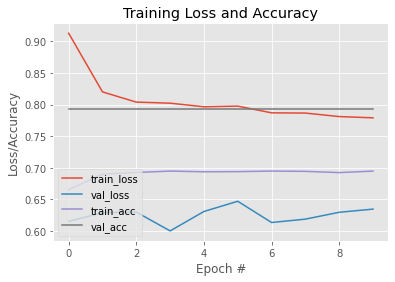

In [ ]:
# plot the training loss and accuracy


N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Model/"+ dt_string+".png")
plt.show()

In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from keras.layers import Activation, Dense, MaxPooling2D

model = Sequential()
model.add(Conv2D(200,(3,3),input_shape=face_images.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])
model.summary()

checkpoint=ModelCheckpoint('model-{epoch:03d}.model', monitor='val_loss', verbose = 0, save_best_only = True,mode='auto')
H = model.fit(trainX,trainY,epochs = 20, callbacks = [checkpoint], validation_data=(testX, testY))

NameError: ignored

In [ ]:
IMAGE_PATHS=['MaskTrainDataset/JPEGImages/00000a0f3efefef6.jpg',
     'MaskTrainDataset/JPEGImages/000004243e3cbf37.jpg',
     'MaskTrainDataset/JPEGImages/00008dfffc3c3f1c.jpg',
     'MaskTrainDataset/JPEGImages/004c381010ffffff.jpg',
     'MaskTrainDataset/JPEGImages/4848dc7e3efeacbc.jpg',
     'MaskTrainDataset/JPEGImages/60e0ecefefececc0.jpg',
     'MaskTrainDataset/JPEGImages/00c6cf8f8fdfcf8f.jpg',
     'MaskTrainDataset/JPEGImages/0f37f662600081e1.jpg',
     'MaskTrainDataset/JPEGImages/0000fdfcbc000660.jpg',
     'MaskTrainDataset/JPEGImages/0ff99100498989cf.jpg',
     'MaskTrainDataset/JPEGImages/00000c3e3e3e3c3e.jpg',
     'MaskTrainDataset/JPEGImages/0000d8fe1f09bfff.jpg',
     'MaskTrainDataset/JPEGImages/0f3f7f3720f0c000.jpg',
     'MaskTrainDataset/JPEGImages/1b1bdfdac9c80102.jpg',
     'MaskTrainDataset/JPEGImages/0fbf2f2c39b0f0f0.jpg',
     'MaskTrainDataset/JPEGImages/00000000046e677f.jpg',
     'MaskTrainDataset/JPEGImages/000000080e1e3e3e.jpg']
print(IMAGE_PATHS)

In [ ]:
#load the saved model

import keras

# serialize the model to disk
print("[INFO] saving mask detector model...")


saved_model_path = "Model"


#tf.saved_model.save(model, saved_model_path)
model.save(saved_model_path)



In [ ]:
import tensorflow as tf
#print(dt_string)
model = keras.models.load_model("Model/"+dt_string + ".h5")
detect_fn=tf.saved_model.load("Model")
#detect_fn = keras.models.load_model("Model/mask_detector_Adam_2020_12_25_15_34_55.h5")

In [ ]:
"""
for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    #input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()
"""

In [ ]:
#load the saved model RAdam
"""
print('loading model...')
opt = tfa.optimizers.RectifiedAdam(
    lr=1e-3,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)

ranger = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5, name='Lookahead',)

model = tf.keras.models.load_model('mask_detector_2020_12_19_07_20.h5', custom_objects={'Lookahead': ranger})

print('model loaded')
"""

In [ ]:

#train the saved model again 
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
"""
opt = tfa.optimizers.RectifiedAdam(
    lr=INIT_LR,
    total_steps=5000,
    warmup_proportion=0.1,
    min_lr=INIT_LR
)
"""
# Utilisation de l'optimizer dans un model (déjà configuré avant)




In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:


# train the head of the network
print("[INFO] training head...")
"""
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),

	validation_data=(testX, testY),

	epochs=EPOCHS
  )
"""
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),

	validation_data=(testX, testY),

	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10})




In [ ]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))


In [ ]:

# plot the training loss and accuracy

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Model/"+ dt_string+"_V1_1.png")
plt.show()

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("Model/"+ dt_string+ "_V1_1.h5")

In [ ]:
"""
for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    image_np = np.tile(
        np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    input_tensor = np.expand_dims(image_np, 0)
    detections = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()
"""